In [1]:
library(Cairo)
library(dplyr)
library(egg)
library(ggplot2)
library(grid)
library(gtable)
library(MatrixGenerics)
library(reshape2)
library(scales)
library(Seurat)
library(targets)
library(tibble)
library(viridisLite)
library(zoo)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: gridExtra


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


Loading required package: ggplot2

Loading required package: matrixStats


Attaching package: 'matrixStats'


The following object is masked from 'package:dplyr':

    count



Attaching package: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, col

In [2]:
objs <- list(
  AscendingColon = tar_read(human.cell.landscape.pca_b515e040),
  Cerebellum = tar_read(human.cell.landscape.pca_2e0c7801),
  Pancreas = tar_read(human.cell.landscape.pca_c2fc94ec)
)

In [3]:
tar_load(human.cell.landscape.k)
tar_load(human.cell.landscape.select.k)
print(
  human.cell.landscape.k %>%
    group_by(label) %>%
    summarise(k = 1 + which.max(explained_variance / k <= 0.8))
)

# A tibble: 9 x 2
  label                   k
  <chr>               <dbl>
1 AdultAscendingColon     5
2 AdultCerebellum         7
3 AdultMuscle             6
4 AdultPancreas           4
5 AdultPleura             5
6 AdultTemporalLobe       5
7 AdultUterus             4
8 FetalMuscle             8
9 Placenta                5


In [4]:
spca <- list(
  AscendingColon = subset(human.cell.landscape.select.k, label == "AdultAscendingColon" & k == 5)$model[[1]],
  Cerebellum = subset(human.cell.landscape.select.k, label == "AdultCerebellum" & k == 7)$model[[1]],
  Pancreas = subset(human.cell.landscape.select.k, label == "AdultPancreas" & k == 10)$model[[1]]
)

In [5]:
enframe(objs) %>% rowwise() %>% reframe(name, head(colnames(value)))

name,head(colnames(value))
<chr>,<chr>
AscendingColon,AdultAscendingColon_1.AACCTATAGCATACCTGA
AscendingColon,AdultAscendingColon_1.ACGTTGTGCAATTTCATA
AscendingColon,AdultAscendingColon_1.CTCGCAACTTATGACACT
AscendingColon,AdultAscendingColon_1.CTCGCACAACAAACCTGA
AscendingColon,AdultAscendingColon_1.CTCGCACTCCATCAACAA
AscendingColon,AdultAscendingColon_1.ACGAGCACTTATTATGTA
Cerebellum,AdultCerebellum_1.ACGAGCATTCCAACGTTG
Cerebellum,AdultCerebellum_1.AAGCGGCGTGGCTGATCA
Cerebellum,AdultCerebellum_1.AGGACTGGTACAAGTTTA


In [6]:
gene_expl_var <- \(model, npcs = 10) rowSums(
  model@feature.loadings[, 1:npcs]^2 *
    rep(model@stdev[1:npcs]^2, each = nrow(model@feature.loadings))
)

In [7]:
genelist <- names(which(gene_expl_var(objs[[1]][["pca"]]) >= 0.1)) %>%
  union(names(which(gene_expl_var(objs[[2]][["pca"]]) >= 0.1))) %>%
  union(names(which(gene_expl_var(objs[[3]][["pca"]]) >= 0.1))) %>%
  union(rownames(spca[[1]]@feature.loadings)[rowAnys(spca[[1]]@feature.loadings[, 1:3] != 0)]) %>%
  union(rownames(spca[[2]]@feature.loadings)[rowAnys(spca[[2]]@feature.loadings[, 1:3] != 0)]) %>%
  union(rownames(spca[[3]]@feature.loadings)[rowAnys(spca[[3]]@feature.loadings[, 1:3] != 0)])
print(tibble(genelist))
dendro <- objs %>%
  sapply(
    \(obj) FetchData(obj, genelist) %>%
      as.matrix() %>%
      `[`(, match(genelist, colnames(.))) %>%
      scale() %>%
      t(),
    simplify = FALSE
  ) %>%
  do.call(cbind, .) %>%
  replace(!is.finite(.), 0) %>%
  pmax(-10) %>%
  pmin(10) %>%
  dist() %>%
  hclust(method = "average") %>%
  as.dendrogram()
head(labels(dendro))
genelist <- genelist[order.dendrogram(dendro)]

# A tibble: 852 x 1
   genelist
   <chr>   
 1 MT-CO1  
 2 MT-RNR2 
 3 FABP1   
 4 MT-CO3  
 5 CXCL14  
 6 MT-ND4  
 7 MT-ATP6 
 8 MT-CO2  
 9 MT-CYB  
10 DCN     
# i 842 more rows


Warning message:
"The following requested variables were not found (10 out of 171 shown): CALB2, GPR17, S100A12, RP11-89N17.4, CLDN5, SCG2, CHGA, NNAT, BCAN, GFAP"
Warning message:
"The following requested variables were not found (10 out of 74 shown): FABP1, ADAMDEC1, PLA2G2A, PHGR1, CA7, DNASE1L3, ADH1B, LYPD8, OTOP2, SFRP2"
Warning message:
"The following requested variables were not found (10 out of 133 shown): FABP1, CXCL14, ADAMDEC1, CA7, DNASE1L3, BEST4, LYPD8, RERGL, OTOP2, PCK1"


[1] "SVIP" "MT1M" "MT1X" "MT1E" "MT2A" "XBP1"

In [8]:
rownames(spca[[1]]@feature.loadings)[rowAnys(spca[[1]]@feature.loadings[, 1:3] != 0)] %>% intersect(genelist)

[1] "MT-CO1" "MT-CO3" "MT-ND4" "MT-CO2" "MT-CYB" "DCN"    "CFD"    "LYZ"   
 [9] "C1QA"   "LUM"    "ADH1B"  "AIF1"   "FCER1G" "TYROBP" "C1R"

In [9]:
spca[[3]]@feature.loadings[, 1] %>% subset(. != 0) %>% names %>% intersect(genelist)

[1] "CLPS"   "CPA1"   "CPB1"   "PNLIP"  "CTRB1"  "PRSS1"  "CELA3B" "GP2"   
 [9] "PRSS2"  "CTRC"

In [10]:
rownames(spca[[3]]@feature.loadings)[rowAnys(spca[[3]]@feature.loadings[, 1:3] != 0)]

[1] "CCL2"    "RGS1"    "CCL3"    "MT-CO3"  "MMP7"    "S100A4"  "ALOX5AP"
 [8] "CLPS"    "CPA1"    "CPB1"    "S100A6"  "MT-CO1"  "PNLIP"   "TMSB10" 
[15] "CTRB1"   "B2M"     "TMSB4X"  "C1QB"    "FCER1G"  "PRSS1"   "TYROBP" 
[22] "LAPTM5"  "CELA3B"  "VSIG4"   "C1QA"    "GP2"     "S100A10" "PRSS2"  
[29] "CTRC"    "ANXA2"

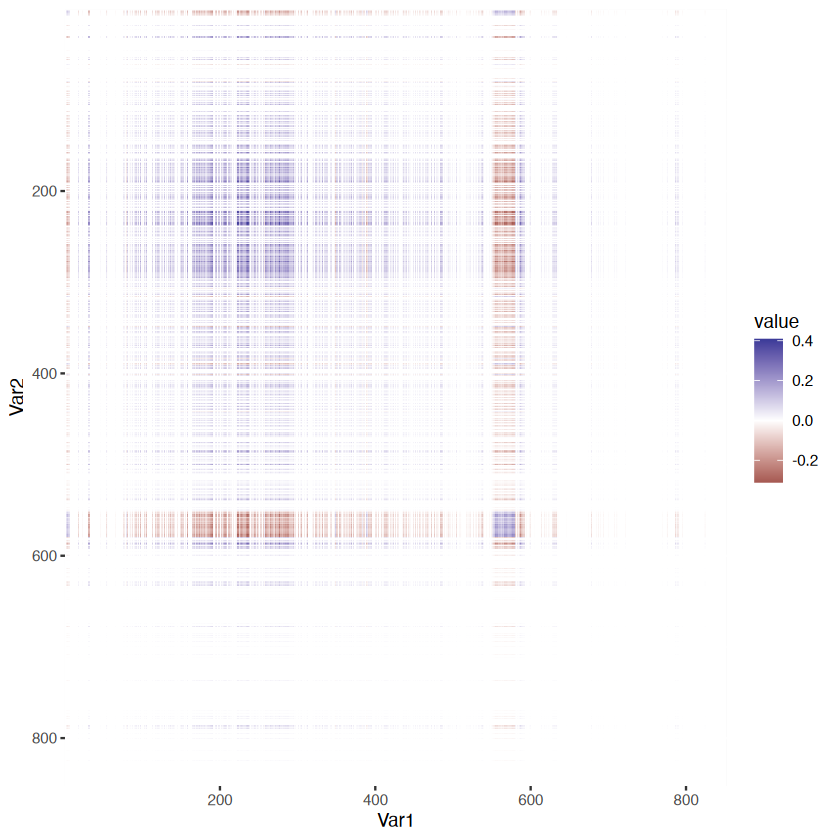

In [11]:
objs[[3]][["pca"]]@feature.loadings %>%
  `[`(match(genelist, rownames(.)), 1) %>%
  replace(is.na(.), 0) %>%
  tcrossprod() %>%
  `*`(objs[[3]][["pca"]]@stdev[1]^2) %>%
  melt() %>%
  ggplot(aes(Var1, Var2, fill=value)) +
  geom_raster() +
  scale_y_reverse() +
  scale_fill_gradient2() +
  coord_cartesian(exp=F)

In [12]:
spca[[1]]@stdev

[1] 1.955741 1.800541 1.688809

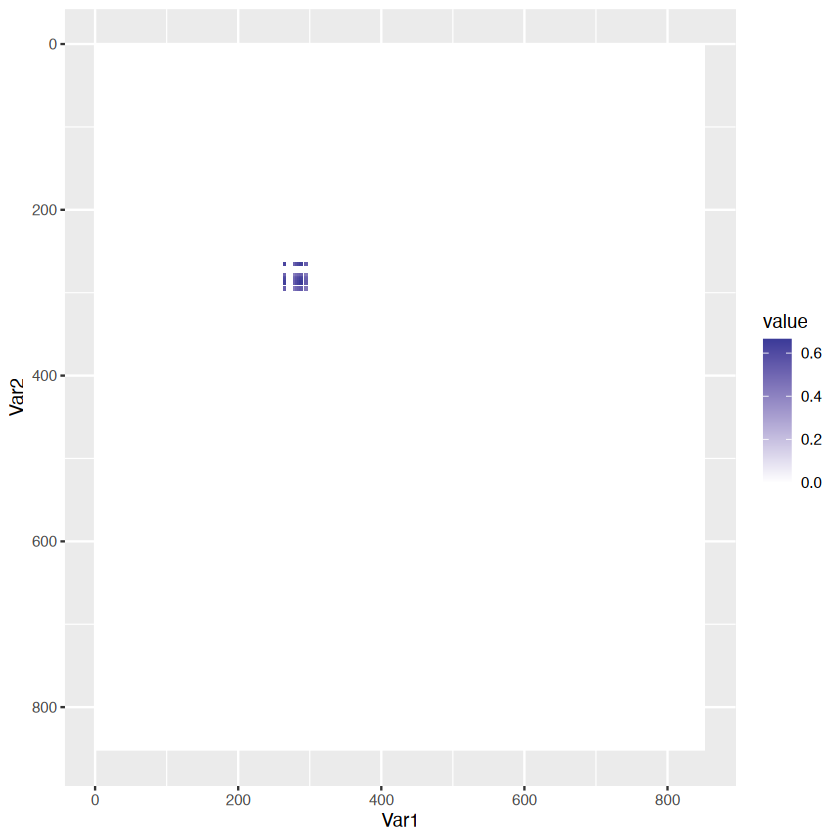

In [13]:
library(ggrastr)
sample <- 3
PC <- 2
printwidth <- 5
rep(0, length(genelist)) %>%
  replace(
    match(spca[[sample]]@feature.loadings[, PC] %>% subset(. != 0) %>% names, genelist),
    spca[[sample]]@feature.loadings[, PC] %>% subset(. != 0)
  ) %>%
  rollapply(
    printwidth,
    \(v) v[which.max(abs(v))],
    partial = TRUE
  ) %>%
  tcrossprod() %>%
  `*`(spca[[sample]]@stdev[PC]^2) %>%
  melt() %>%
  ggplot(aes(Var1, Var2, fill=value)) +
  geom_raster() +
  scale_y_reverse() +
  scale_fill_gradient2()

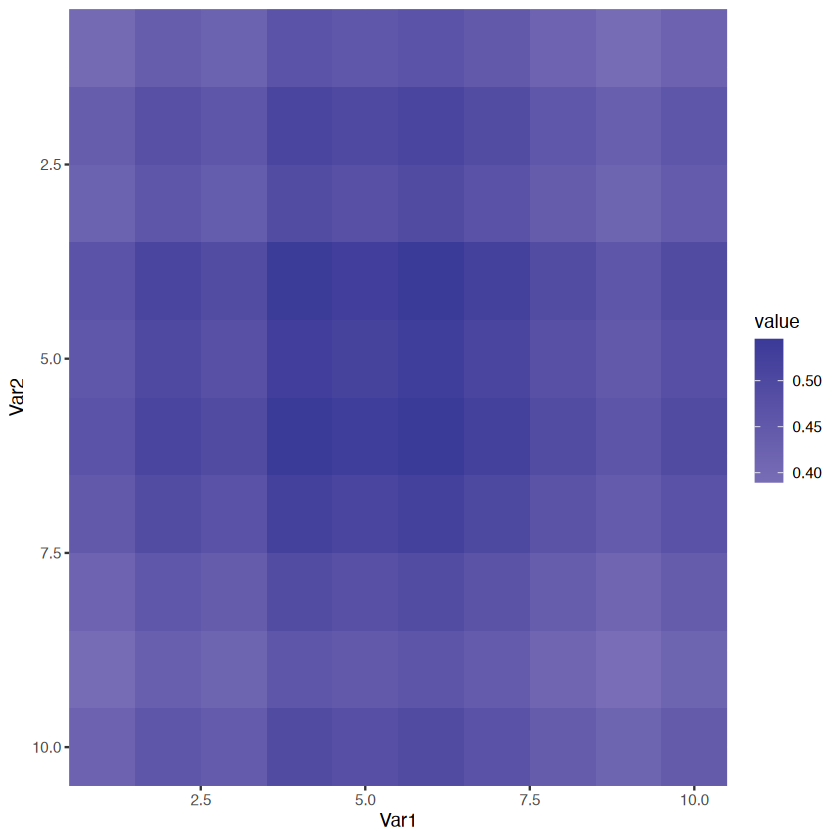

In [14]:
sample <- 3
PC <- 3
spca[[sample]]@feature.loadings[, PC] %>% subset(. != 0) %>%
  `[`(value = order(match(names(.), genelist))) %>%
  tcrossprod() %>%
  `*`(spca[[sample]]@stdev[PC]^2) %>%
  melt() %>%
  ggplot(aes(Var1, Var2, fill=value)) +
  geom_raster() +
  scale_y_reverse() +
  scale_fill_gradient2() +
  coord_cartesian(exp=F)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.335620 -0.007171 -0.002425  0.007461  0.013781  0.999506 

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.3511019 -0.0046828 -0.0005831  0.0039480  0.0043480  0.9998635 

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.3376769 -0.0013805  0.0001426  0.0058101  0.0072502  0.9998972 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.127463 -0.001755  0.002065  0.006444  0.011932  0.728341 


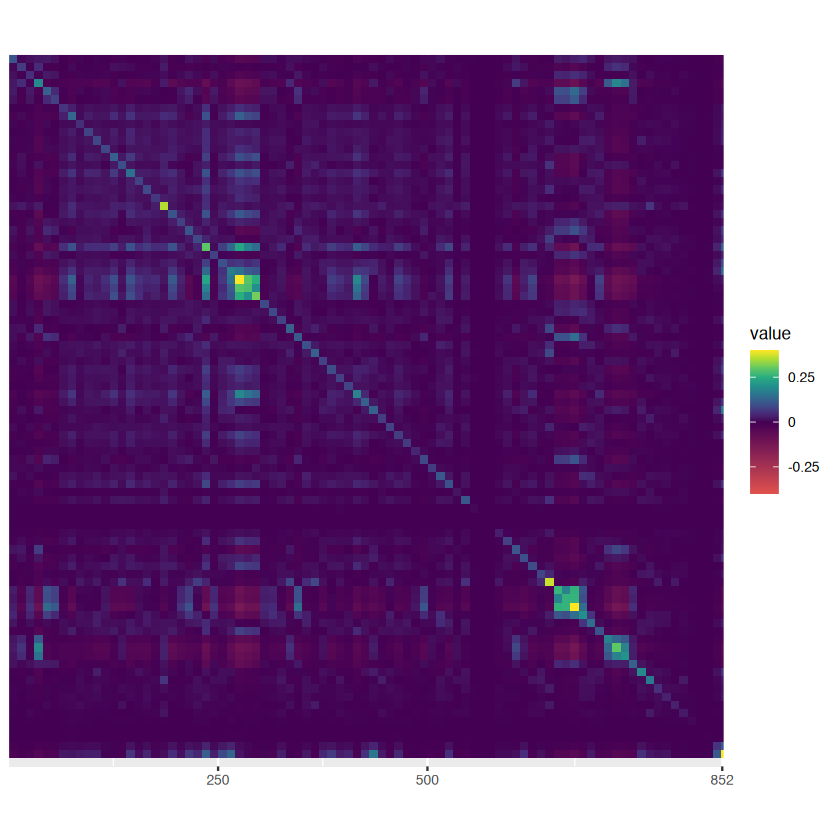

In [42]:
grab_genelist <- function(covar) {
  covar[
    match(genelist, rownames(covar)),
    match(genelist, rownames(covar))
  ] %>%
    replace(!is.finite(.), 0) %>%
    matrix(nrow = nrow(.), dimnames = rep(list(genelist), 2))
}
plot_covar <- function(covar, legend=T, breaks=c(250, 500, length(genelist)), as_tiles=FALSE, pix=10, squish=TRUE) {
  Var1x <- seq((pix + 1) / 2, nrow(covar) + pix / 2, by=pix)
  Var2y <- seq((pix + 1) / 2, ncol(covar) + pix / 2, by=pix)
  data <- covar %>%
    matrix(nrow = nrow(.)) %>%
    melt() %>%
    mutate(
      Var1 = Var1x[cut(Var1, c(seq(0, nrow(covar), by=pix), Inf))],
      Var2 = Var2y[cut(Var2, c(seq(0, ncol(covar), by=pix), Inf))],
    ) %>%
    group_by(
      Var1, Var2
    ) %>%
    summarise_all(mean)
  print(summary(data$value))
  data %>%
    ggplot(
      aes(Var1, Var2, fill=value)
    ) +
    (if (as_tiles) geom_tile() else geom_raster()) +
    scale_fill_gradientn(
      colors = if (squish)
        c(seq_gradient_pal("#e0524d", viridis(10)[1])(seq(0, 1, length.out=9))[-9], viridis(9))
      else
        c(seq_gradient_pal("#e0524d", viridis(10)[1])(seq(0, 1, length.out=9))[-9], viridis(16), rep(viridis(2)[2], 5)),
      limits = if (squish)
        c(-0.4, 0.4)
        else
        c(-0.4, 1),
      breaks = c(-0.25, 0, 0.25, 0.5, 0.75, 1),
      labels = as.numeric,
      oob = if (squish) scales::squish else scales::censor,
    ) +
    scale_x_continuous(breaks=breaks) +
    scale_y_reverse(breaks=breaks, labels=rep("", length(breaks))) +
    coord_cartesian(
      c(0.5, nrow(covar) + 0.5),
      c(0.5, ncol(covar) + 0.5),
      exp=F
    ) +
    labs(x = NULL, y = NULL) +
    theme(
      aspect.ratio = 1,
      axis.text = element_text(size = unit(8, "pt")),
      legend.text = element_text(size = unit(8, "pt")),
      legend.title = element_text(size = unit(10, "pt")),
      legend.position = if (legend) "right" else "none"
    )
}
summary(as.numeric(objs[[1]]@misc$covar))
summary(as.numeric(objs[[2]]@misc$covar))
summary(as.numeric(objs[[3]]@misc$covar))
objs[[2]]@misc$covar %>%
  grab_genelist() %>%
  plot_covar()

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.005745  0.000000  0.004035  0.007793  0.010496  0.615789 
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.004131 0.015094 0.023027 0.032558 0.312749 


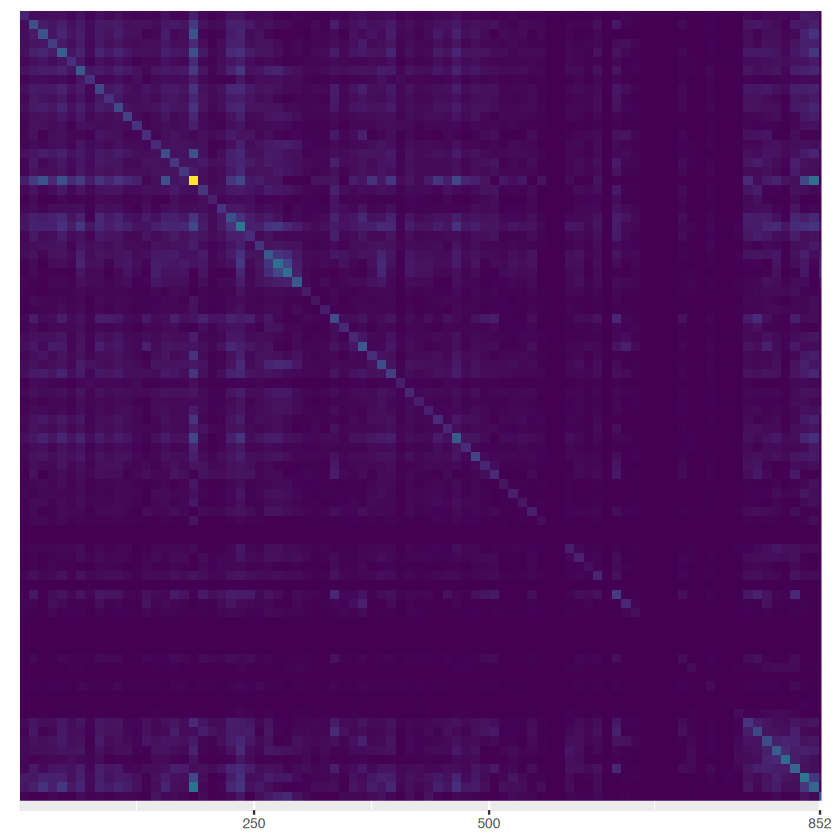

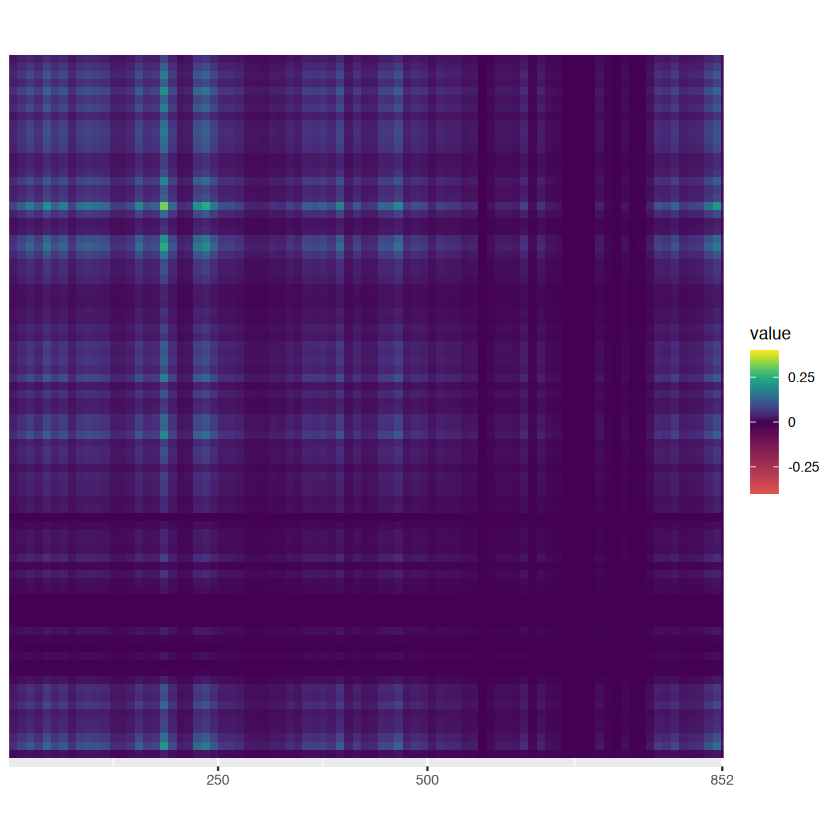

In [43]:
resizeBrightSpots <- \(v, width = 3) {
  if (is.matrix(v)) {
    M <- v
    M %>%
      apply(
        1,
        \(v) rollapply(
          v,
          width,
          \(v) v[which.max(abs(v))],
          partial = TRUE
        )
      ) %>%
      apply(
        1,
        \(v) rollapply(
          v,
          width,
          \(v) v[which.max(abs(v))],
          partial = TRUE
        )
      ) %>%
      matrix(
        nrow = nrow(M),
        dimnames = dimnames(M)
      )
  } else {
    rollapply(
      v,
      width,
      \(v) v[which.max(abs(v))],
      partial = TRUE
    ) %>%
      setNames(names(v))
  }
}
plot_sample_covar <- function(M) {
  M %>% grab_genelist %>%
    # resizeBrightSpots %>%
    plot_covar(legend=F)
}
plot_pc <- function(obj, pc, legend=F) {
  obj[["pca"]]@feature.loadings %>%
    `[`(match(genelist, rownames(.)), pc) %>%
    replace(is.na(.), 0) %>%
    resizeBrightSpots() %>%
    tcrossprod() %>%
    `*`(obj[["pca"]]@stdev[pc]^2) %>%
    plot_covar(legend=legend)
}
plot_sample_covar(objs[[1]]@misc$covar)
plot_pc(objs[[1]], 1, legend=TRUE)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.0000000 0.0000000 0.0006505 0.0000000 0.6769685 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5389  0.5773  0.6011  0.6022  0.6249  0.6770 


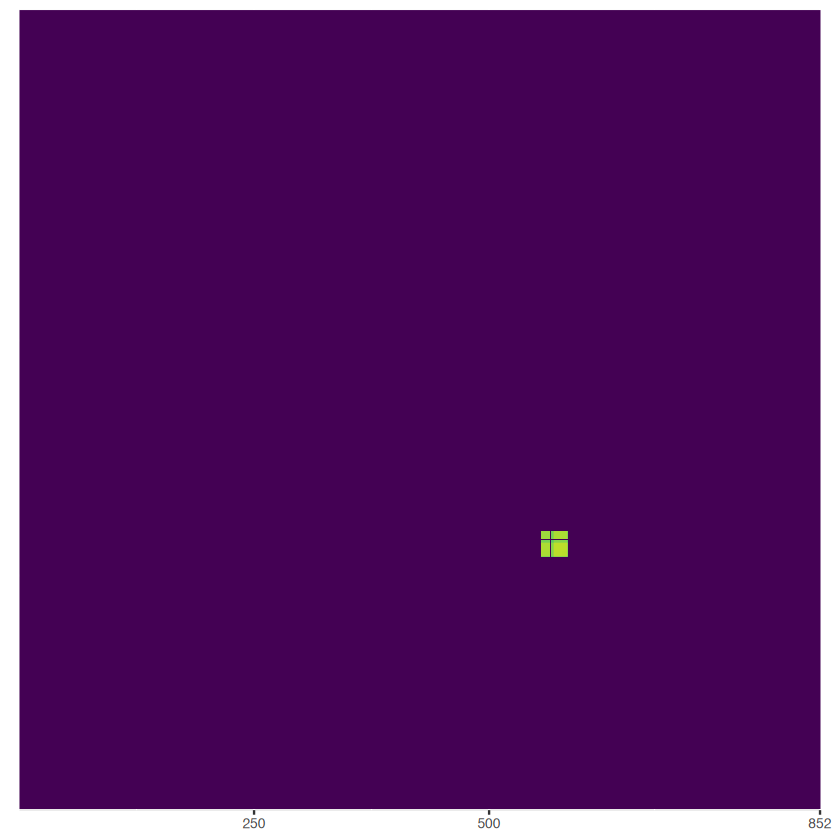

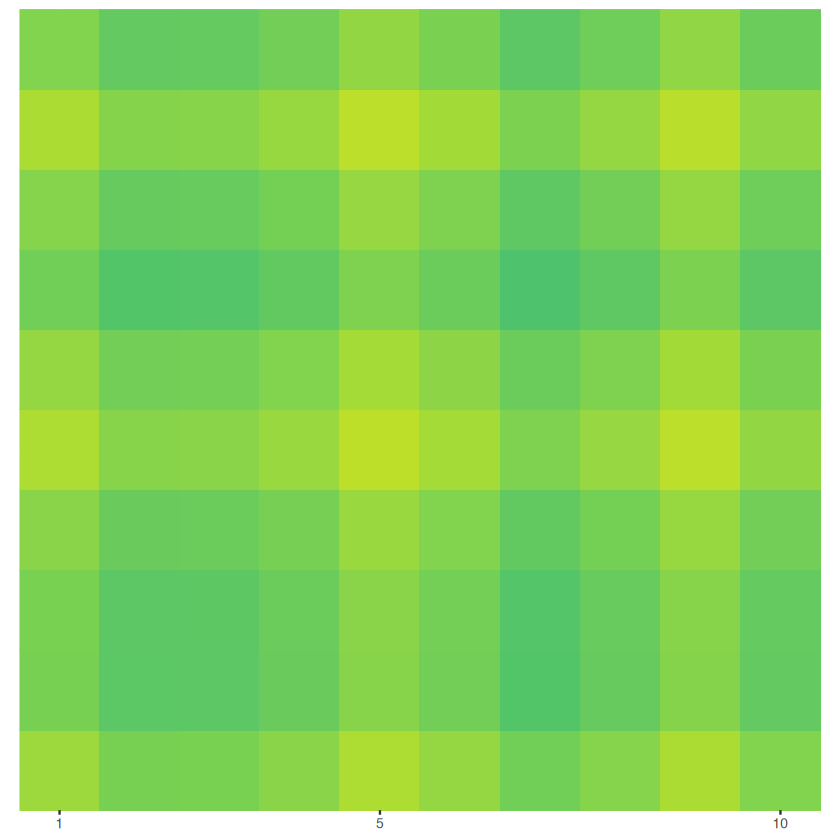

In [55]:
plot_spc <- function(model, spc, legend=F) {
  model@feature.loadings[, spc, drop=T] %>%
    subset(. != 0) %>%
    `[`(match(genelist, names(.))) %>%
    replace(is.na(.), 0) %>%
    resizeBrightSpots(9) %>%
    tcrossprod() %>%
    `*`(model@stdev[spc]^2) %>%
    plot_covar(legend=legend, pix=1, squish=FALSE)
}
zoom_spc <- function(model, spc, legend=F, breaks=c(1, 5, 10)) {
  model@feature.loadings[, spc, drop=T] %>%
    subset(. != 0) %>%
    `[`(order(match(names(.), genelist))) %>%
    tcrossprod() %>%
    `*`(model@stdev[spc]^2) %>%
    plot_covar(legend=legend, breaks, as_tiles=TRUE, pix=1, squish=FALSE)
}
plot_spc(spca[[3]], 1)
zoom_spc(spca[[3]], 1)

In [45]:
CairoPDF("figure/FigS1.pdf", w=8.5, h=11)
grid.draw(
  cbind(
    rbind(
      ggplotGrob(plot_sample_covar(objs[[1]]@misc$covar)),
      ggplotGrob(plot_sample_covar(objs[[2]]@misc$covar)),
      ggplotGrob(plot_sample_covar(objs[[3]]@misc$covar))
    ),
    rbind(
      ggplotGrob(plot_pc(objs[[1]], 1)),
      ggplotGrob(plot_pc(objs[[2]], 1)),
      ggplotGrob(plot_pc(objs[[3]], 1))
    ),
    rbind(
      ggplotGrob(plot_pc(objs[[1]], 2)),
      ggplotGrob(plot_pc(objs[[2]], 2)),
      ggplotGrob(plot_pc(objs[[3]], 2))
    ),
    rbind(
      ggplotGrob(plot_pc(objs[[1]], 3)),
      ggplotGrob(plot_pc(objs[[2]], 3)),
      ggplotGrob(plot_pc(objs[[3]], 3))
    ),
    rbind(
      ggplotGrob(plot_spc(spca[[1]], 1)),
      ggplotGrob(plot_spc(spca[[2]], 1)),
      ggplotGrob(plot_spc(spca[[3]], 1))
    ),
    rbind(
      ggplotGrob(plot_spc(spca[[1]], 2)),
      ggplotGrob(plot_spc(spca[[2]], 2)),
      ggplotGrob(plot_spc(spca[[3]], 2))
    ),
    rbind(
      ggplotGrob(plot_spc(spca[[1]], 3)),
      ggplotGrob(plot_spc(spca[[2]], 3)),
      ggplotGrob(plot_spc(spca[[3]], 3))
    )
  )
)
dev.off()

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.005745  0.000000  0.004035  0.007793  0.010496  0.615789 
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.127463 -0.001755  0.002065  0.006444  0.011932  0.728341 
      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.1397437  0.0000000  0.0007121  0.0061754  0.0070800  0.5004802 
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.004131 0.015094 0.023027 0.032558 0.312749 
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.261853 -0.008244  0.001169  0.008139  0.021753  0.495683 
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.227481  0.000000  0.003194  0.013169  0.021564  0.290129 
      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.0922044 -0.0001657  0.0007411  0.0068569  0.0125072  0.1130171 
      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.3106163 -0.0045125  0.0000763  0.0005348  0.0056219  0.3595713 


pdf 
  2

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      5       5       5       5       5       5 


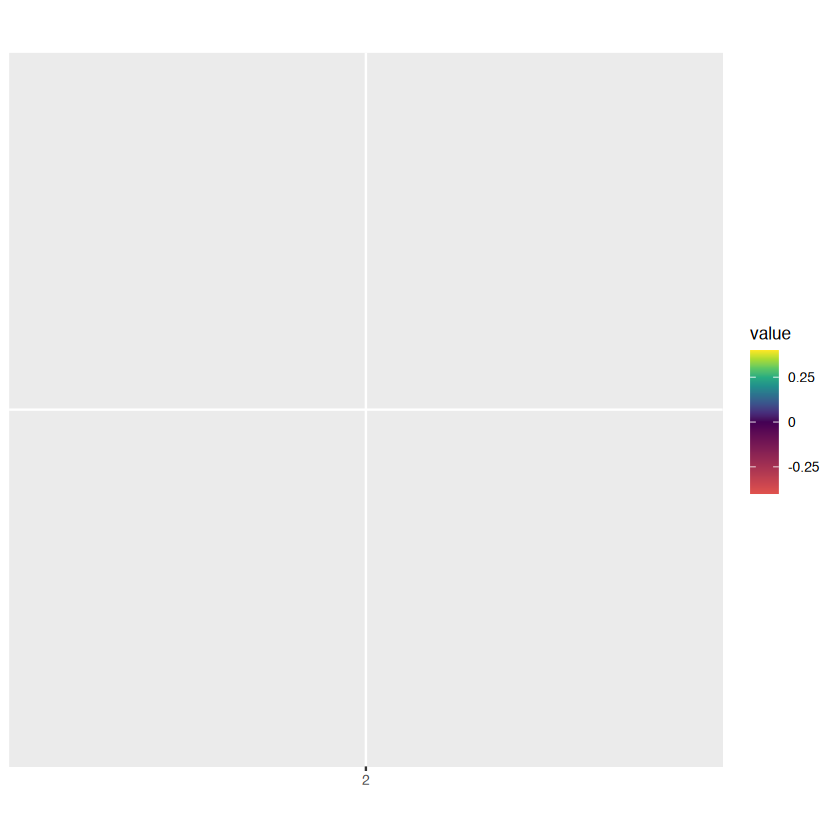

In [46]:
plot_covar(matrix(1:9, nrow=3), breaks=2)

In [47]:
ggplotGrob(plot_covar(matrix(1:9, nrow=3), breaks=2))$heights

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      5       5       5       5       5       5 


 [1] 5.5points                                                                               
 [2] 0points                                                                                 
 [3] 0cm                                                                                     
 [4] 0cm                                                                                     
 [5] 0cm                                                                                     
 [6] 0points                                                                                 
 [7] 0cm                                                                                     
 [8] 0cm                                                                                     
 [9] 1null                                                                                   
[10] sum(0.0966514459665145cm, max(0points, -0.0966514459665145cm), 0.342045601217657cm, 0cm)
[11] 0cm                                                    

In [48]:
theme_bw()$axis.ticks

List of 6
 $ colour       : chr "grey20"
 $ linewidth    : NULL
 $ linetype     : NULL
 $ lineend      : NULL
 $ arrow        : logi FALSE
 $ inherit.blank: logi TRUE
 - attr(*, "class")= chr [1:2] "element_line" "element"

In [49]:
theme_get()$axis.ticks.length
convertUnit(theme_get()$axis.ticks.length, "cm")

[1] 2.75points

[1] 0.0966514459665145cm

In [50]:
convertUnit(unit(0.342045601217657, "cm"), "pt")

[1] 9.73214000000003points

In [51]:
names(theme_bw())

[1] "line"                             "rect"                            
  [3] "text"                             "title"                           
  [5] "aspect.ratio"                     "axis.title"                      
  [7] "axis.title.x"                     "axis.title.x.top"                
  [9] "axis.title.x.bottom"              "axis.title.y"                    
 [11] "axis.title.y.left"                "axis.title.y.right"              
 [13] "axis.text"                        "axis.text.x"                     
 [15] "axis.text.x.top"                  "axis.text.x.bottom"              
 [17] "axis.text.y"                      "axis.text.y.left"                
 [19] "axis.text.y.right"                "axis.text.theta"                 
 [21] "axis.text.r"                      "axis.ticks"                      
 [23] "axis.ticks.x"                     "axis.ticks.x.top"                
 [25] "axis.ticks.x.bottom"              "axis.ticks.y"                    
 [27] "axis.ticks.y.left"                "axis.ticks.y.right"              
 [29] "axis.ticks.theta"                 "axis.ticks.r"                    
 [31] "axis.minor.ticks.x.top"           "axis.minor.ticks.x.bottom"       
 [33] "axis.minor.ticks.y.left"          "axis.minor.ticks.y.right"        
 [35] "axis.minor.ticks.theta"           "axis.minor.ticks.r"              
 [37] "axis.ticks.length"                "axis.ticks.length.x"             
 [39] "axis.ticks.length.x.top"          "axis.ticks.length.x.bottom"      
 [41] "axis.ticks.length.y"              "axis.ticks.length.y.left"        
 [43] "axis.ticks.length.y.right"        "axis.ticks.length.theta"         
 [45] "axis.ticks.length.r"              "axis.minor.ticks.length"         
 [47] "axis.minor.ticks.length.x"        "axis.minor.ticks.length.x.top"   
 [49] "axis.minor.ticks.length.x.bottom" "axis.minor.ticks.length.y"       
 [51] "axis.minor.ticks.length.y.left"   "axis.minor.ticks.length.y.right" 
 [53] "axis.minor.ticks.length.theta"    "axis.minor.ticks.length.r"       
 [55] "axis.line"                        "axis.line.x"                     
 [57] "axis.line.x.top"                  "axis.line.x.bottom"              
 [59] "axis.line.y"                      "axis.line.y.left"                
 [61] "axis.line.y.right"                "axis.line.theta"                 
 [63] "axis.line.r"                      "legend.background"               
 [65] "legend.margin"                    "legend.spacing"                  
 [67] "legend.spacing.x"                 "legend.spacing.y"                
 [69] "legend.key"                       "legend.key.size"                 
 [71] "legend.key.height"                "legend.key.width"                
 [73] "legend.key.spacing"               "legend.key.spacing.x"            
 [75] "legend.key.spacing.y"             "legend.frame"                    
 [77] "legend.ticks"                     "legend.ticks.length"             
 [79] "legend.axis.line"                 "legend.text"                     
 [81] "legend.text.position"             "legend.title"                    
 [83] "legend.title.position"            "legend.position"                 
 [85] "legend.position.inside"           "legend.direction"                
 [87] "legend.byrow"                     "legend.justification"            
 [89] "legend.justification.top"         "legend.justification.bottom"     
 [91] "legend.justification.left"        "legend.justification.right"      
 [93] "legend.justification.inside"      "legend.location"                 
 [95] "legend.box"                       "legend.box.just"                 
 [97] "legend.box.margin"                "legend.box.background"           
 [99] "legend.box.spacing"               "panel.background"                
[101] "panel.border"                     "panel.spacing"                   
[103] "panel.spacing.x"                  "panel.spacing.y"                 
[105] "panel.grid"                       "panel.gr

In [141]:
guide1 <- ggplotGrob(
  objs[[2]]@misc$covar %>%
    grab_genelist() %>%
    plot_covar() %>%
    `+`(theme(legend.position = "bottom"))
)
guide2 <- ggplotGrob(
  ggplot(data.frame(x=1:2, value=0:1), aes(x, 0, fill=value)) +
    geom_tile() +
    scale_fill_viridis_c("value") +
    theme(legend.position = "bottom")
)
CairoPDF("figure/FigS1.pdf", w=8.5, h=11)
L <-
  set_panel_size(
    g = cbind(
      rbind(
        ggplotGrob(plot_sample_covar(objs[[1]]@misc$covar) + theme(plot.margin = margin(25.5, 5.5, 25.5, 5.5))),
        ggplotGrob(plot_sample_covar(objs[[2]]@misc$covar) + theme(plot.margin = margin(25.5, 5.5, 25.5, 5.5))),
        ggplotGrob(plot_sample_covar(objs[[3]]@misc$covar) + theme(plot.margin = margin(25.5, 5.5, 25.5, 5.5)))
      ),
      rbind(
        ggplotGrob(plot_pc(objs[[1]], 1)),
        ggplotGrob(plot_pc(objs[[2]], 1)),
        ggplotGrob(plot_pc(objs[[3]], 1))
      ),
      rbind(
        ggplotGrob(plot_pc(objs[[1]], 2)),
        ggplotGrob(plot_pc(objs[[2]], 2)),
        ggplotGrob(plot_pc(objs[[3]], 2))
      ),
      rbind(
        ggplotGrob(plot_pc(objs[[1]], 3)),
        ggplotGrob(plot_pc(objs[[2]], 3)),
        ggplotGrob(plot_pc(objs[[3]], 3))
      ),
      rbind(
        ggplotGrob(plot_spc(spca[[1]], 1)),
        ggplotGrob(plot_spc(spca[[2]], 1)),
        ggplotGrob(plot_spc(spca[[3]], 1))
      )
    ),
    w = unit(1, "in"),
    h = unit(1, "in")
  )
print(L$layout[grep("panel", L$layout$name), ])
Lcol <- unique(L$layout$l[grep("panel", L$layout$name)])
print(Lcol)
L <- gtable(
  L$widths,
  unit.c(unit(0.4, "in"), sum(L$heights))
) %>%
  gtable_add_grob(
    list(
      textGrob(expression(S^2), gp = gpar(fontfamily = "Helvetica", fontsize = 10)),
      textGrob("PC1", gp = gpar(fontfamily = "Helvetica", fontsize = 10)),
      textGrob("PC2", gp = gpar(fontfamily = "Helvetica", fontsize = 10)),
      textGrob("PC3", gp = gpar(fontfamily = "Helvetica", fontsize = 10)),
      textGrob("SPC1", gp = gpar(fontfamily = "Helvetica", fontsize = 10)),
      L
    ),
    l = c(
      Lcol[1:5],
      1
    ),
    r = c(
      Lcol[1:5],
      length(L$widths)
    ),
    t = c(1, 1, 1, 1, 1, 2)
  )
Rheight <- (1*72 + 2*25.5 - 4*5.5 - 4*(2.75 + 9.732)) / 3
print(Rheight)
R <- set_panel_size(
  g = rbind(
    ggplotGrob(ggplot() + labs(title = "SPC1-3") + theme_void()) %>%
      `$<-`(
        "heights",
        value = .$heights %>%
          replace(1:9, unit(0, "null")) %>%
          replace(2, unit(0.4, "in"))
      ),
    ggplotGrob(zoom_spc(spca[[1]], 1)),
    ggplotGrob(zoom_spc(spca[[1]], 2)),
    ggplotGrob(zoom_spc(spca[[1]], 3)),
    ggplotGrob(zoom_spc(spca[[2]], 1)),
    ggplotGrob(zoom_spc(spca[[2]], 2)),
    ggplotGrob(zoom_spc(spca[[2]], 3)),
    ggplotGrob(zoom_spc(spca[[3]], 1, breaks=c(1, 10))),
    ggplotGrob(zoom_spc(spca[[3]], 2, breaks=c(1, 10))),
    ggplotGrob(zoom_spc(spca[[3]], 3, breaks=c(1, 10)))
  ),
  w = unit(Rheight, "pt"),
  h = unit(Rheight, "pt")
)
gtable(
  w = unit(c(6, 1), "in"),
  h = unit(c(6, 1), "in")
) %>%
  gtable_add_grob(
    list(
      L,
      R,
      guide1$grobs[[match("guide-box-bottom", guide1$layout$name)]],
      guide2$grobs[[match("guide-box-bottom", guide2$layout$name)]]
    ),
    t = c(1, 1, 2, 2),
    l = c(1:2, 1:2)
  ) %>%
  grid.draw()
dev.off()

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.127463 -0.001755  0.002065  0.006444  0.011932  0.728341 
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.005745  0.000000  0.004035  0.007793  0.010496  0.615789 
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.127463 -0.001755  0.002065  0.006444  0.011932  0.728341 
      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.1397437  0.0000000  0.0007121  0.0061754  0.0070800  0.5004802 
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.004131 0.015094 0.023027 0.032558 0.312749 
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.261853 -0.008244  0.001169  0.008139  0.021753  0.495683 
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.227481  0.000000  0.003194  0.013169  0.021564  0.290129 
      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.0922044 -0.0001657  0.0007411  0.0068569  0.0125072  0.1130171 
      Min.  

pdf 
  2

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.127463 -0.001755  0.002065  0.006444  0.011932  0.728341 


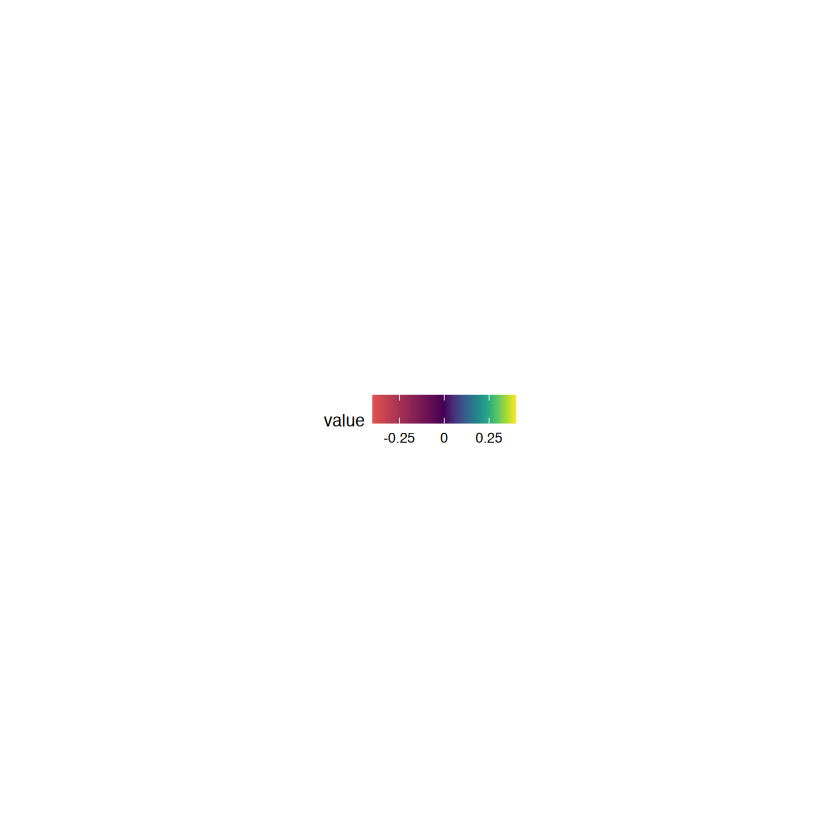

In [140]:
scl <-
        objs[[2]]@misc$covar %>%
          grab_genelist() %>%
          plot_covar() %>%
          `+`(theme(legend.position = "bottom")) %>%
          ggplotGrob
grid.draw(scl$grobs[[match("guide-box-bottom", scl$layout$name)]])

In [60]:
L$layout[grep("panel", L$layout$name), ]

,t,l,b,r,z,clip,name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
6,9,7,9,7,1,on,panel
28,25,7,25,7,1,on,panel
50,41,7,41,7,1,on,panel
72,9,20,9,20,1,on,panel
94,25,20,25,20,1,on,panel
116,41,20,41,20,1,on,panel
138,9,33,9,33,1,on,panel
160,25,33,25,33,1,on,panel
182,41,33,41,33,1,on,panel
